# Step 0. Read in Data and NLTK basics

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [33]:
# Read in data
df = pd.read_csv('reviews-cleaned.csv')
print(df.shape)

(3848, 4)


In [34]:
df.head()

,Name,Stars,Description,Label
0,Elizabeth,5,Wanda’s dedication to her her customers is ama...,Positive
1,rajuahmedr,2,“Excellent Service and Support!”“A Smooth and ...,Negative
2,Pamela,5,Du Good is one of the best banks . They help m...,Positive
3,Wanda,5,Kristin went above and beyond to help this pro...,Positive
4,sharveish wara,5,This app is very good,Positive


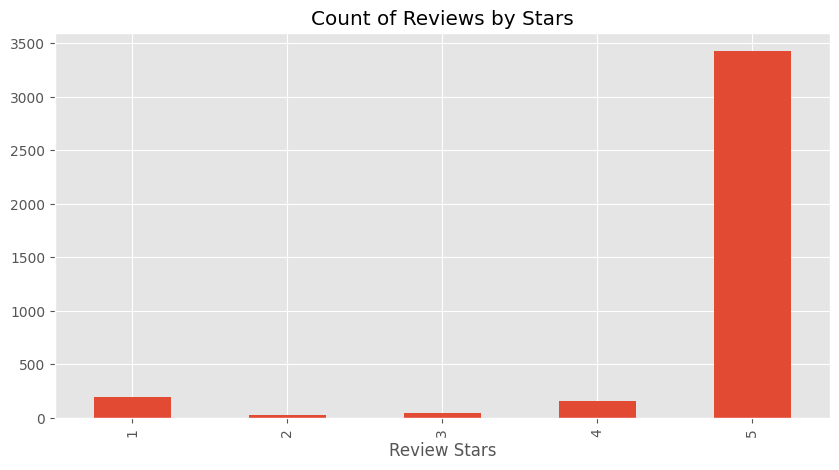

In [35]:
ax = df['Stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [36]:
example = df['Description'][50]
print(df['Stars'][50])
print(example)

5
Marrissa got to bottom of my problem quickly.


In [37]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Marrissa', 'got', 'to', 'bottom', 'of', 'my', 'problem', 'quickly', '.']

In [38]:
nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\duynt\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


[('Marrissa', 'NNP'),
 ('got', 'VBD'),
 ('to', 'TO'),
 ('bottom', 'VB'),
 ('of', 'IN'),
 ('my', 'PRP$'),
 ('problem', 'NN'),
 ('quickly', 'RB'),
 ('.', '.')]

In [39]:
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\duynt\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\duynt\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  (PERSON Marrissa/NNP)
  got/VBD
  to/TO
  bottom/VB
  of/IN
  my/PRP$
  problem/NN
  quickly/RB
  ./.)


# Step 1. VADER Sentiment Scoring

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\duynt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [42]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [43]:
sia.polarity_scores(example)

{'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}

In [44]:
# Run the polarity score on the entire dataset
res = {}
df['id'] = range(1, len(df) + 1)
df.head()
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Description']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/3848 [00:00<?, ?it/s]

## Plot VADER results

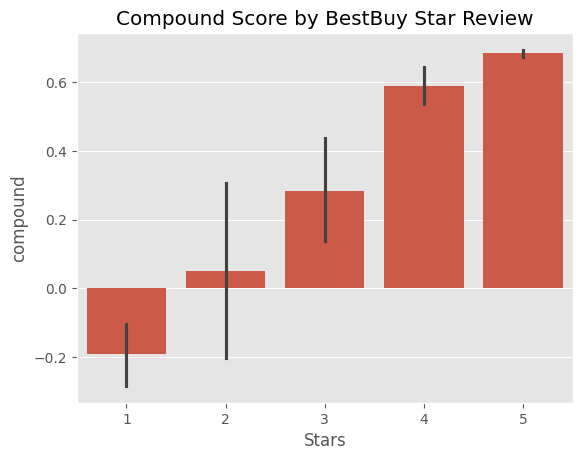

In [45]:
vaders = pd.DataFrame(res).T
vaders
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

ax = sns.barplot(data=vaders, x='Stars', y='compound')
ax.set_title('Compound Score by BestBuy Star Review')
plt.show()

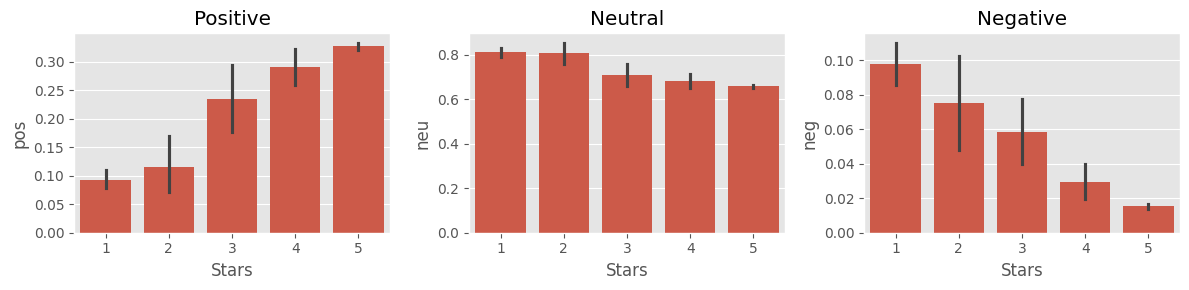

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Stars', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Stars', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Stars', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3: Roberta Pretrained Model

In [47]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [49]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Marrissa got to bottom of my problem quickly.


{'neg': 0.278, 'neu': 0.722, 'pos': 0.0, 'compound': -0.4019}

In [50]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.07614247, 'roberta_neu': 0.6544655, 'roberta_pos': 0.269392}


In [51]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [52]:

res = {}
df = df[:500]
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Description']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [53]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

In [54]:
results_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Name', 'Stars',
       'Description', 'Label'],
      dtype='object')

# Step 3. Combine and compare

In [55]:
results_df

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Name,Stars,Description,Label
0,1,0.0,0.556,0.444,0.9776,0.001831,0.004631,0.993538,Elizabeth,5,Wanda’s dedication to her her customers is ama...,Positive
1,2,0.0,0.692,0.308,0.6996,0.003413,0.047202,0.949386,rajuahmedr,2,“Excellent Service and Support!”“A Smooth and ...,Negative
2,3,0.0,0.580,0.420,0.9062,0.001710,0.016554,0.981736,Pamela,5,Du Good is one of the best banks . They help m...,Positive
3,4,0.0,0.803,0.197,0.4019,0.004979,0.137480,0.857541,Wanda,5,Kristin went above and beyond to help this pro...,Positive
4,5,0.0,0.556,0.444,0.4927,0.001943,0.008948,0.989109,sharveish wara,5,This app is very good,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.0,1.000,0.000,0.0000,0.303130,0.560426,0.136445,danieldadams,5,Every thing,Positive
496,497,0.0,1.000,0.000,0.0000,0.260458,0.547807,0.191735,Safa Safu,1,Everything,Negative
497,498,0.0,0.530,0.470,0.7959,0.001323,0.024711,0.973966,Brett,5,Kenzie was a great help to me setting up my fi...,Positive
498,499,0.0,0.690,0.310,0.9337,0.001332,0.025683,0.972984,Mundo de Crianças,5,I recommend DuGood Credit Union for its solid ...,Positive


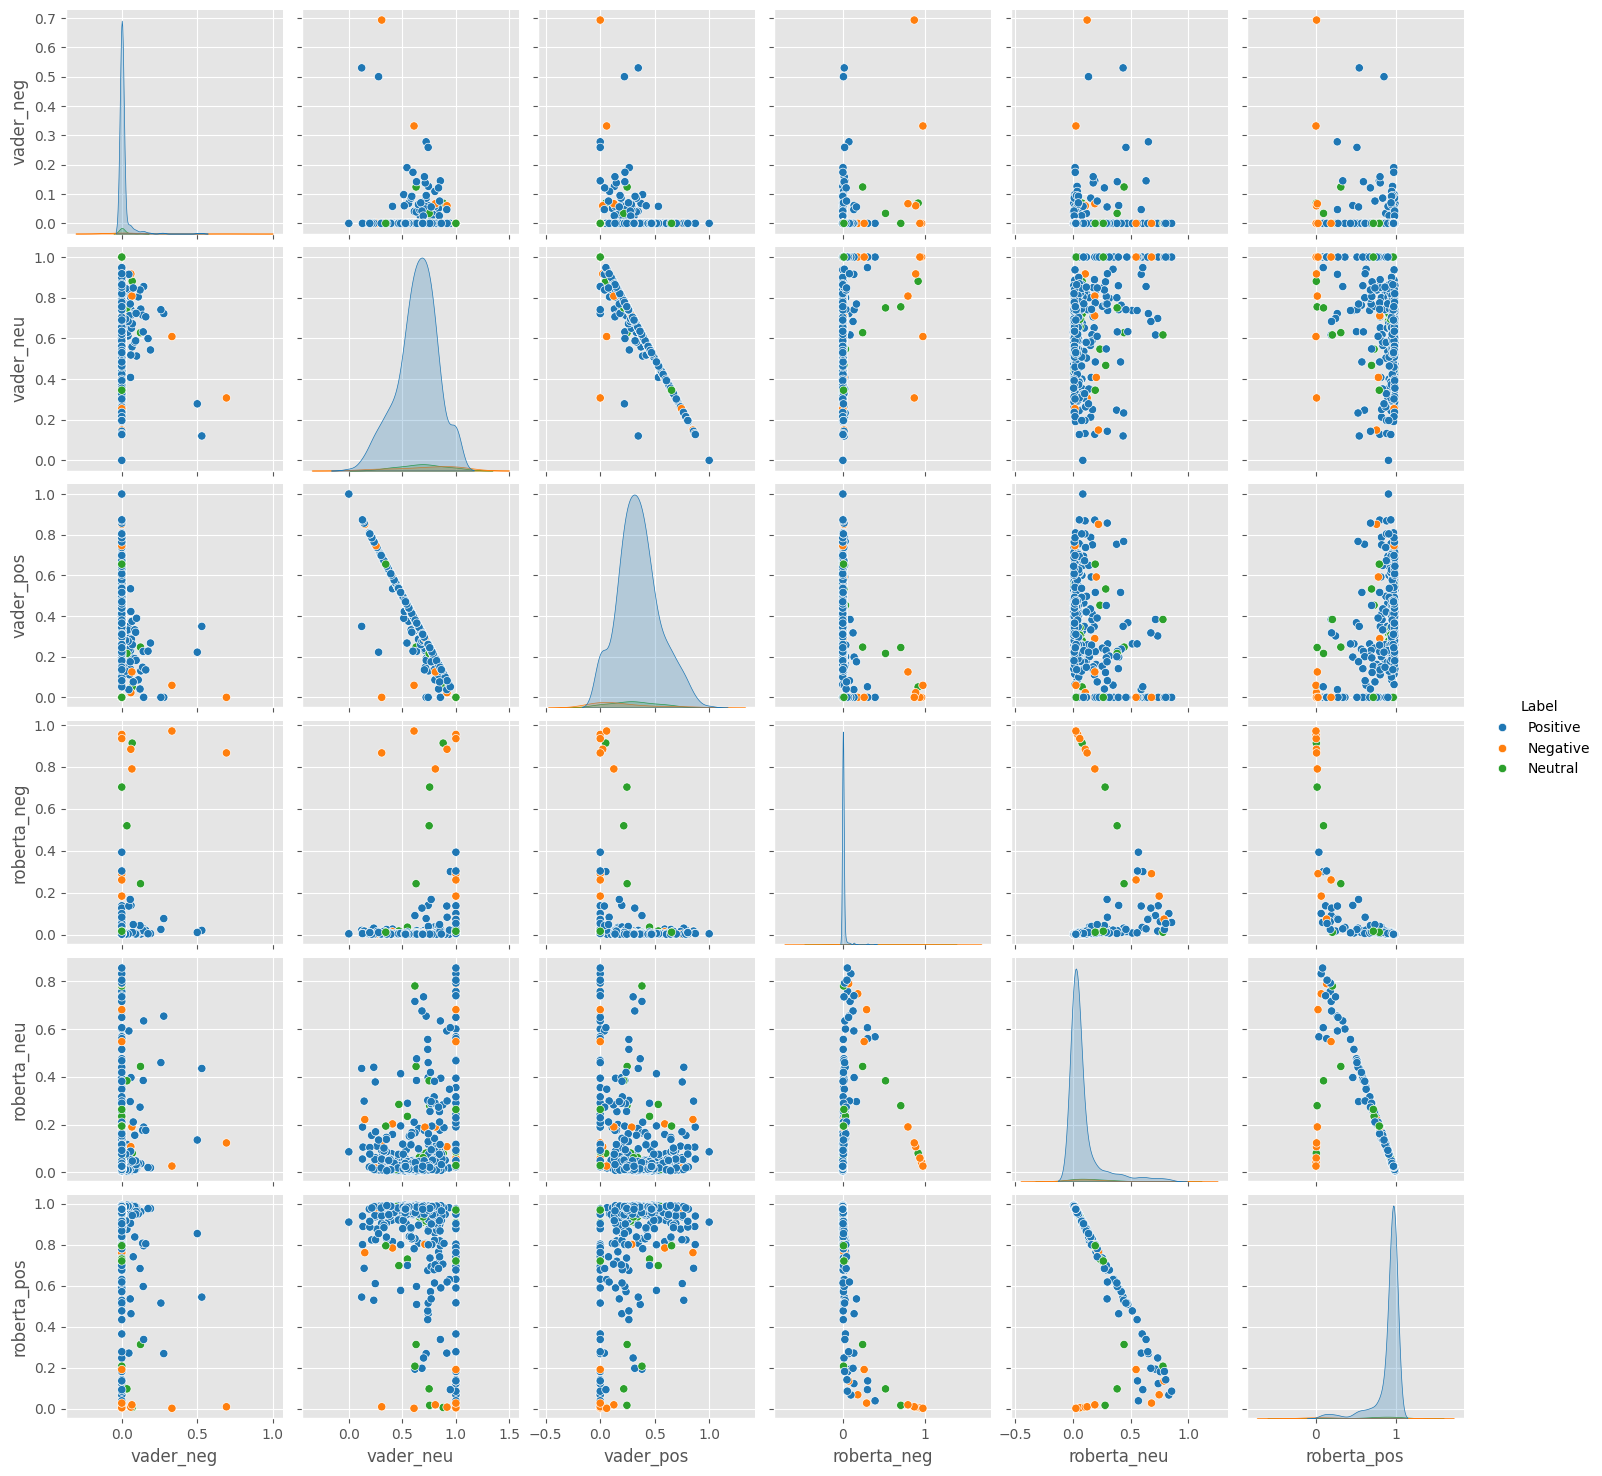

In [61]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Label',
            palette='tab10')
plt.show()

# Step 4: Review Examples

In [57]:
results_df.query('Stars == 4').sort_values('roberta_pos', ascending=False)['Description'].values

array(['KRISTIN AT THE BEAUMONT BRANCH IS THE BEST WE WORKED WITH HER ON A CAR LOAN IN SEPTEMBER AND JUST COMPLETED ONE LAST WEEK.  SHE MAKES EVERYTHING SO SIMPLE. WE LOVE HER AND HOW EASY SHE MADE IT TO GET INTO OUR NEW VEHICLES FOR MY HUSBAND AND ME.CARLTON AND KIM GREEN',
       'Very helpful!Thanks WB',
       'All the ladies were kind and friendly. The staff assisted with all items and all questions I had.',
       'Very helpful and patient with the questions and process.',
       'Customer service was stellar, however, we were expecting to be set up with a joint account (two names) and I was the only one on it. I think we figured it out though.',
       'Good experience. I would prefer better faster communiciation via email.',
       'Gud experience', 'Need to give more options but other wise good',
       'The person who helped was genuinely friendly and seemed to really care. I am terrible with names or I would mention her.',
       'All stuff are careful taking care the busine

In [58]:
results_df.query('Stars == 1') \
    .sort_values('vader_pos', ascending=False)['Description'].values[0]

'Nice and easy'

In [59]:
results_df.query('Stars == 5') \
    .sort_values('roberta_neg', ascending=False)['Description'].values[0]

'Why my account'

In [60]:
results_df.query('Stars == 5') \
    .sort_values('vader_neg', ascending=False)['Description'].values[0]

'Easy, fast no pressure'